In [5]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# Load the data from the .npy file
data_path = 'data/ai_ready'
file_name = '1_ready.npy'
full_path = os.path.join(data_path, file_name)
east_component_data = np.load(full_path)

# Define a window size and overlap (in number of samples)
freq = 25 #25 samples per second (For Sitkin Data)
window_size = 15 * 60 * 25  #15 minute long window
overlap = 500

# Sliding window function
def sliding_window(data, window_size, overlap):
    step = window_size - overlap
    windows = [data[i:i+window_size] for i in range(0, len(data)-window_size+1, step)]
    return windows

# Apply the sliding window function to the data
windows = sliding_window(east_component_data, window_size, overlap)

# Feature extraction: calculate mean, std, etc. for each window
features = []
for window in windows:
    mean = np.mean(window)
    std = np.std(window)
    max_val = np.max(window)
    min_val = np.min(window)
    features.append([mean, std, max_val, min_val])

# Convert the features list to a NumPy array
features = np.array(features)

# Print the shape of the features array to verify
print('Features shape:', features.shape, '\n')

# Print the first few rows of the features array
print('First 5 rows of features:')
print(features[:5], '\n')

# Print summary statistics for each feature
feature_names = ['Mean', 'Std', 'Max', 'Min']
for i, name in enumerate(feature_names):
    print(f'{name} - Mean: {np.mean(features[:, i]):.2f}, Std: {np.std(features[:, i]):.2f}, '
          f'Min: {np.min(features[:, i]):.2f}, Max: {np.max(features[:, i]):.2f}')

# Print the data types of the features
print('Data types of features:', features.dtype)

# Optionally, save the features to a new .npy file
output_file = os.path.join(data_path, '1_ready_features.npy')
#os.makedirs(data_path, exist_ok=True)
np.save(output_file, features)

Features shape: (98, 4) 

First 5 rows of features:
[[ 1.02876323e+01  7.67438691e+02  2.92081630e+03 -2.65583314e+03]
 [ 2.01107103e+00  7.94315758e+02  2.94481316e+03 -3.52310441e+03]
 [ 2.46257613e+01  7.21556154e+02  3.15327550e+03 -2.68478806e+03]
 [ 1.25693991e+01  7.41027306e+02  2.83721236e+03 -2.48450586e+03]
 [ 2.69797553e+01  7.59949501e+02  3.05015291e+03 -3.10917569e+03]] 

Mean - Mean: -0.99, Std: 28.26, Min: -60.00, Max: 43.67
Std - Mean: 705.57, Std: 109.98, Min: 472.28, Max: 879.07
Max - Mean: 2988.41, Std: 532.99, Min: 2021.81, Max: 5361.26
Min - Mean: -2987.16, Std: 578.50, Min: -5160.68, Max: -1973.58
Data types of features: float64


In [6]:
#Also compute overall statistics

def statistics(data):
    #returns mean, min, max, and standard deviation of input data

    return(np.mean(data), np.min(data), np.max(data), np.std(data))

#sup = shorthand for super/overall
sup_mean, sup_min, sup_max, sup_std = statistics(east_component_data)

#save to dictions
sup_stats = {'Mean':sup_mean, 'Minimum':sup_min, 'Maximum':sup_max, 'Standard Deviation':sup_std}

#print values
print('Overall Statistics')
print()

for val in sup_stats:
    print(val + ' : ' + str(sup_stats[val]))

Overall Statistics

Mean : -1.1258282691394494
Minimum : -5160.683020029368
Maximum : 5361.255229470142
Standard Deviation : 714.0061233840125


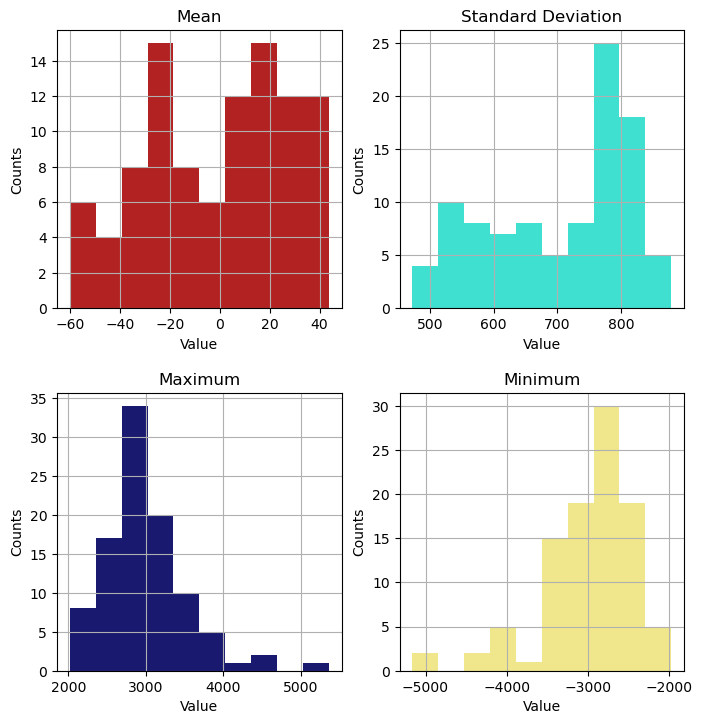

In [7]:
#put features into labeled dataframe
stats_df = pd.DataFrame(features, columns=['Mean', 'Std', 'Max', 'Min'])

#plot histogram for each stat
fig, axs = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(7,7)
plt.tight_layout(h_pad=4)

axs[0][0].hist(stats_df['Mean'], color='firebrick')
axs[0][0].set_title('Mean')
axs[0][0].set_xlabel('Value')
axs[0][0].set_ylabel('Counts')
axs[0][0].grid()

axs[0][1].hist(stats_df['Std'], color='turquoise')
axs[0][1].set_title('Standard Deviation')
axs[0][1].set_xlabel('Value')
axs[0][1].set_ylabel('Counts')
axs[0][1].grid()

axs[1][0].hist(stats_df['Max'], color='midnightblue')
axs[1][0].set_title('Maximum')
axs[1][0].set_xlabel('Value')
axs[1][0].set_ylabel('Counts')
axs[1][0].grid()

axs[1][1].hist(stats_df['Min'], color='khaki')
axs[1][1].set_title('Minimum')
axs[1][1].set_xlabel('Value')
axs[1][1].set_ylabel('Counts')
axs[1][1].grid();

/tmp/ipykernel_2253/3103230396.py:18: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(np.min(f), np.max(f))


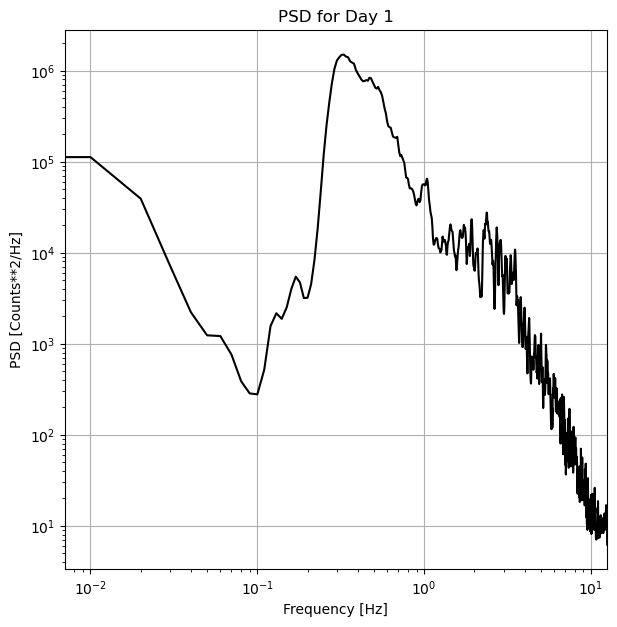

In [8]:
from scipy import signal

#compute power spectral density using Welch's Method
fs = 25 #sampling rate in hz
window = 10*10 #second window to compute ffts over, at least 10x the period of the lowest freq you care about

#generate a Tukey window to taper the data with
taper = signal.windows.tukey(len(east_component_data))

#welch returns frequency and power given a signal and sampling rate
f, Pxx_den = signal.welch(east_component_data*taper, fs, nperseg=window*fs)

plt.figure(figsize=(7,7))
plt.loglog(f, Pxx_den, color='k')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [Counts**2/Hz]')
plt.title('PSD for Day '+file_name.split('_')[0])
plt.xlim(np.min(f), np.max(f))
plt.grid();

/tmp/ipykernel_2253/1363491574.py:12: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(t/3600, f, np.log10(np.abs(Zxx)), shading='gouraud', cmap='magma')


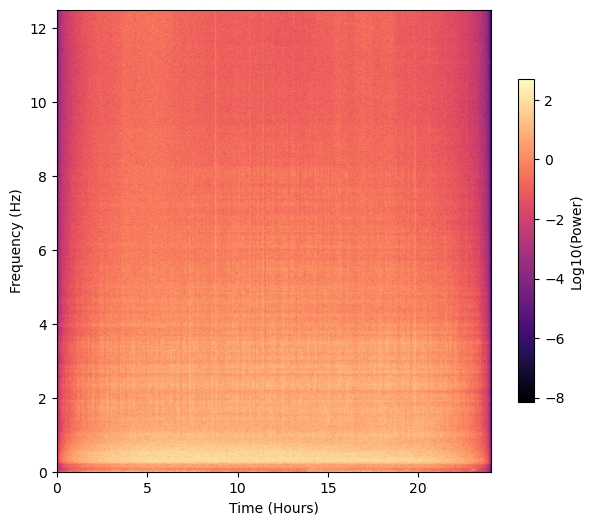

In [9]:
#plot spectrogram
fs = 25
window = 10*10

#generate a Tukey window to taper the data with
taper = signal.windows.tukey(len(east_component_data))

#compute the spectrogram
f, t, Zxx = signal.stft(taper*east_component_data, fs=fs, nperseg=window*fs, noverlap=200)

plt.figure(figsize=(7,6))
plt.pcolormesh(t/3600, f, np.log10(np.abs(Zxx)), shading='gouraud', cmap='magma')
plt.colorbar(label='Log10(Power)', shrink=0.7)
plt.xlabel('Time (Hours)')
plt.ylabel('Frequency (Hz)');

In [ ]:
##This shows that the 2023 Shishaldin Eruption data, like the Geldingadlir data, is centered around 0, but has an even higher standard deviation, for reasons not fully understood. The frequency also covers a far greater range than the Geldingadalir data, with a high amount of energy as high as 4 Hz, and also showing some temporal variation over the day.